In [2]:
"""
====================
Tracking Quick Start
====================

This example shows how to perform fast fiber tracking using DIPY_
[Garyfallidis12]_.

We will use Constrained Spherical Deconvolution (CSD) [Tournier07]_ for local
reconstruction and then generate deterministic streamlines using the fiber
directions (peaks) from CSD and fractional anisotropic (FA) from DTI as a
stopping criteria for the tracking.

Let's load the necessary modules.
"""

import numpy as np
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.tracking.utils import random_seeds_from_mask
from dipy.reconst.dti import TensorModel
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response,auto_response_ssst)
from dipy.direction import peaks_from_model
from dipy.data import fetch_stanford_hardi, read_stanford_hardi, get_sphere,fetch_stanford_labels,read_stanford_labels
from dipy.segment.mask import median_otsu
# from dipy.viz import actor, window
from dipy.io.image import save_nifti
from nibabel.streamlines import save as save_trk
from nibabel.streamlines import Tractogram
from dipy.tracking.streamline import Streamlines
from dipy.tracking import utils
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table

from dipy.data import get_fnames
from dipy.io.image import load_nifti_data, load_nifti, save_nifti
import matplotlib.pyplot as plt
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from scipy.ndimage.morphology import binary_dilation
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

from dipy.reconst import shm
from dipy.direction import peaks
import nibabel as nib
import os

/tmp/ipykernel_3086/903397807.py:40: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation


In [3]:
ids ="sub-A00000300"

In [4]:
fdwi=f'/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/{ids}/{ids}_dwi.nii_EC.nii.gz'
fbval =f'/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/{ids}/{ids}_dwi.bval'
fbvec_adj= f'/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/{ids}/{ids}_adjs.bvec'
altas_dti =f'/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/{ids}/{ids}_labels.nii.gz'
mask_path =f'/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/{ids}/{ids}_mask.nii'

In [119]:
wmseg_path=f'/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/{ids}/{ids}_wmseg-in-DTI.nii.gz'

In [120]:
wmseg_path_original=f'/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/{ids}/wm.seg.mgz'

In [121]:
white_matter_orig =nib.load(wmseg_path_original)

In [122]:
white_matter_orig.shape

(256, 256, 256)

In [123]:
wm_seg_image = np.array(white_matter_orig.dataobj).astype(np.int)

/tmp/ipykernel_98/2407742234.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  wm_seg_image = np.array(white_matter_orig.dataobj).astype(np.int)


In [124]:
np.unique(wm_seg_image)

array([  0,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 200, 210, 230])

In [125]:
white_matter = load_nifti_data(wmseg_path)

In [126]:
data, last_affine, img = load_nifti(fdwi, return_img=True)

In [127]:
white_matter.shape

(128, 128, 72)

In [128]:
data.shape

(128, 128, 72, 35)

In [129]:
#white_matter=white_matter>3000

In [130]:
np.unique(white_matter)

array([  0,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 200, 210, 230], dtype=uint8)

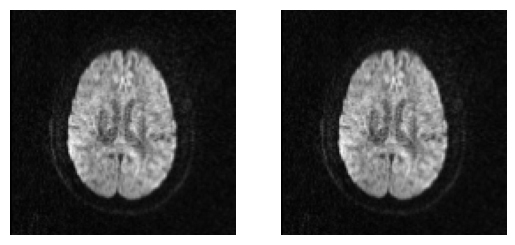

<Figure size 640x480 with 0 Axes>

In [131]:
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 3].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 3].T, cmap='gray', origin='lower')
plt.show()
plt.savefig('data.png', bbox_inches='tight')

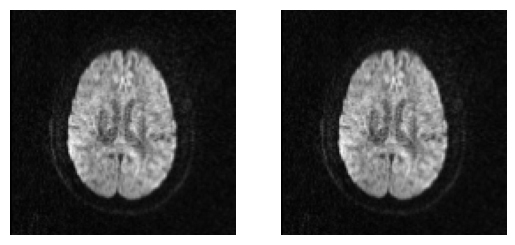

<Figure size 640x480 with 0 Axes>

In [132]:
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, 3].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, 3].T, cmap='gray', origin='lower')
plt.show()
plt.savefig('data.png', bbox_inches='tight')

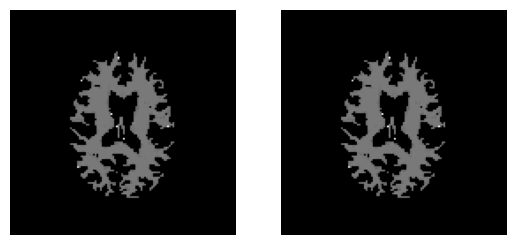

<Figure size 640x480 with 0 Axes>

In [133]:
axial_middle = white_matter.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(white_matter[:, :, axial_middle].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(white_matter[:, :, axial_middle].T, cmap='gray', origin='lower')
plt.show()
plt.savefig('data.png', bbox_inches='tight')

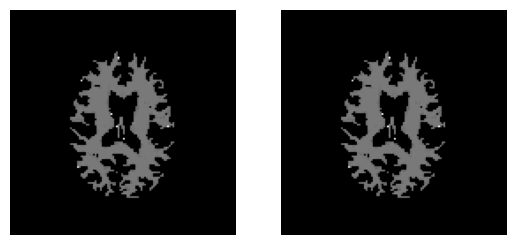

<Figure size 640x480 with 0 Axes>

In [134]:
axial_middle = white_matter.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(white_matter[:, :, axial_middle].T, cmap='gray', origin='lower')
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(white_matter[:, :, axial_middle].T, cmap='gray', origin='lower')
plt.show()
plt.savefig('data.png', bbox_inches='tight')

In [146]:
mask_data, mask_affine, mask_img = load_nifti(mask_path, return_img=True)
    
affine = np.eye(4)
    
seeds = utils.seeds_from_mask(mask_data, mask_affine, density=1)

In [155]:
with open('coord2.txt', 'w') as file:
    for seed in seeds.tolist():
        file.write(str(seed)[1:-1].replace(",", "") +"\n")

In [153]:
str(seed)[1:-1].replace(",", "")
    

'-60.9095458984375 7.280899763107314 1.7439792156219482'

In [ ]:
def save_seed_coords(fdwi,fbval,fbvec, mask_path):
    mask_data, mask_affine, mask_img = load_nifti(mask_path, return_img=True)
    seeds = utils.seeds_from_mask(mask_data, mask_affine, density=1)
    with open('coord2.txt', 'w') as file:
        for seed in seeds.tolist():
            file.write(str(seed)[1:-1].replace(",", "") +"\n")
        

In [108]:
def tractography_preproc(fdwi,fbval,fbvec, mask_path):
    data, last_affine, img = load_nifti(fdwi, return_img=True)
    bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
    gtab = gradient_table(bvals, bvecs)
    mask_data, mask_affine, mask_img = load_nifti(mask_path, return_img=True)
    
    affine = np.eye(4)
    
    seeds = utils.seeds_from_mask(mask_data, affine, density=1)
    stopping_criterion = BinaryStoppingCriterion(mask_data)
    
    csamodel = shm.CsaOdfModel(gtab, 6)
    csapeaks = peaks.peaks_from_model(model=csamodel,
                                  data=data,
                                  sphere=peaks.default_sphere,
                                  relative_peak_threshold=.8,
                                  min_separation_angle=45,
                                  mask=mask_data)
    streamline_generator = LocalTracking(csapeaks, stopping_criterion,
                                     seeds, affine=affine,
                                     step_size=0.5)

    streamlines = Streamlines(streamline_generator)
    
    return streamlines, affine

In [109]:
streamlines, affine =tractography_preproc(fdwi,fbval,fbvec, wmseg_path)

In [110]:
labels, atlas_affine, atlas_img =load_nifti(altas_dti, return_img=True)

In [111]:
new_atlas_data =labels.copy()

In [112]:
for elem, new_elem in zip(np.unique(labels),list(range(np.unique(labels).shape[0]))):
    print(elem, new_elem)
    new_atlas_data[new_atlas_data==elem]=new_elem

0 0
2001 1
2002 2
2101 3
2102 4
2111 5
2112 6
2201 7
2202 8
2211 9
2212 10
2301 11
2302 12
2311 13
2312 14
2321 15
2322 16
2331 17
2332 18
2401 19
2402 20
2501 21
2502 22
2601 23
2602 24
2611 25
2612 26
2701 27
2702 28
3001 29
3002 30
4001 31
4002 32
4011 33
4012 34
4021 35
4022 36
4101 37
4102 38
4111 39
4112 40
4201 41
4202 42
5001 43
5002 44
5011 45
5012 46
5021 47
5022 48
5101 49
5102 50
5201 51
5202 52
5301 53
5302 54
5401 55
5402 56
6001 57
6002 58
6101 59
6102 60
6201 61
6202 62
6211 63
6212 64
6221 65
6222 66
6301 67
6302 68
6401 69
6402 70
7001 71
7002 72
7011 73
7012 74
7021 75
7022 76
7101 77
7102 78
8101 79
8102 80
8111 81
8112 82
8121 83
8122 84
8201 85
8202 86
8211 87
8212 88
8301 89
8302 90
9001 91
9002 92
9011 93
9012 94
9021 95
9022 96
9031 97
9032 98
9041 99
9042 100
9051 101
9052 102
9061 103
9062 104
9071 105
9072 106
9081 107
9082 108
9100 109
9110 110
9120 111
9130 112
9140 113
9150 114
9160 115
9170 116


In [113]:
np.unique(new_atlas_data.astype(np.uint8))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116],
      dtype=uint8)

In [114]:
M, grouping = utils.connectivity_matrix(streamlines, affine,
                                        new_atlas_data.astype(np.uint8),
                                        return_mapping=True,
                                        mapping_as_streamlines=True)

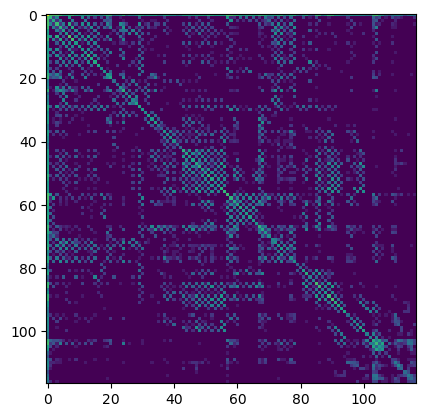

In [115]:
plt.imshow(np.log1p(M), interpolation='nearest')

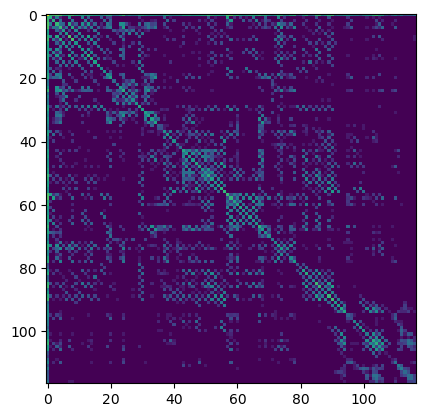

In [88]:
plt.imshow(np.log1p(M), interpolation='nearest')

## Preprocessing All Data

In [4]:
from pathlib import Path

In [10]:
data_package ='/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/'

In [145]:
def preproc_atlas(atlas_data):
    new_atlas_data =atlas_data.copy()
    for elem, new_elem in zip(np.unique(atlas_data),list(range(np.unique(atlas_data).shape[0]))):
        new_atlas_data[new_atlas_data==elem]=new_elem
    return new_atlas_data 

In [146]:
atlas_labels =fetch_atlas_aal()['labels']
for sub_id in Path(data_package).iterdir():
    try:
        if sub_id.is_dir():
         
            altas_dti =f'{sub_id}/{sub_id.name}_label_fs.nii'
            fdwi=f'{sub_id}/{sub_id.name}_dwi.nii_EC.nii.gz'
            fbval =f'{sub_id}/{sub_id.name}_dwi.bval'
            fbvec= f'{sub_id}/{sub_id.name}_adjs.bvec'
            altas_dti =f'{sub_id}/{sub_id.name}_labels.nii.gz'
            mask_path =f'{sub_id}/{sub_id.name}_mask.nii'
            wmseg_path=f'/workspace/datasets/COBRE_preproc_dti/{ids}/{ids}_wmseg-in-DTI.nii.gz'
            
            
            atlas_data, atlas_affine, atlas_img =load_nifti(altas_dti, return_img=True)
            new_atlas_data =preproc_atlas(atlas_data)
            
            streamlines, affine =tractography_preproc(fdwi,fbval,fbvec, wmseg_path)
            M, grouping = utils.connectivity_matrix(streamlines, affine,
                                            new_atlas_data.astype(np.uint8),
                                            return_mapping=True,
                                            mapping_as_streamlines=True)
            print(M[1:,1:].shape)
            data =pd.DataFrame(M[1:,1:], columns=atlas_labels, index =atlas_labels)
            data.to_csv(f'results/cobre_dti_AAL_CSA_WM/{sub_id.name}_dti.csv')
    except Exception as e:
        print(e)

(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
No such file or no access: '/workspace/datasets/COBRE_preproc_dti/sub-A00015759/sub-A00015759_labels.nii.gz'
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
No such file or no access: '/workspace/datasets/COBRE_preproc_dti/sub-A00024372/sub-A00024372_dwi.nii_EC.nii.gz'
(116, 116)
No such file or no access: '/workspace/datasets/COBRE_preproc_dti/sub-A00028402/sub-A00028402_labels.nii.gz'
(116, 116)
No such file or no access: '/workspace/datasets/COBRE_preproc_dti/sub-A00031478/sub-A00031478_labels.nii.gz'
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
No such file or no access: '/workspace/datasets/COBRE_preproc_dti/sub-A00031271/sub-A00031271_labels.nii.gz'
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
(116, 116)
No such file or no access: '/workspace/datasets/COBRE_p

In [14]:
for sub_id in Path(data_package).iterdir():
    try:
        if sub_id.is_dir():
            mask_path =f'{sub_id}/{sub_id.name}_mask.nii'
            mask_data, mask_affine, mask_img = load_nifti(mask_path, return_img=True)
            seeds = utils.seeds_from_mask(mask_data, mask_affine, density=1)
            print(f'{sub_id}/coord2.txt')
            with open(f'{sub_id}/coord2.txt', 'w') as file:
                for seed in seeds.tolist():
                    file.write(str(seed)[1:-1].replace(",", "") +"\n")
    except Exception as e:
        print(e)      

/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00000838/coord2.txt
/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00036844/coord2.txt
/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00016197/coord2.txt
/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00006754/coord2.txt
/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00022509/coord2.txt
/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00014590/coord2.txt
/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00022400/coord2.txt
/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00022727/coord2.txt
/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00001251/coord2.txt
/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00018317/coord2.txt
/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00017147/coord2.txt
/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00013816/coord2.txt
No such file or no access: '/workspace/home/zubrikhi

In [13]:
list(Path(data_package).iterdir())

[PosixPath('/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00000838'),
 PosixPath('/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00036844'),
 PosixPath('/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00000909_TM.mat'),
 PosixPath('/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00016197'),
 PosixPath('/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00001452_TM.mat'),
 PosixPath('/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00006754'),
 PosixPath('/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00022509'),
 PosixPath('/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00014590'),
 PosixPath('/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00000456_labels.nii.gz'),
 PosixPath('/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00022400'),
 PosixPath('/workspace/home/zubrikhina/datasets/COBRE_preproc_dti/sub-A00001452_labels.nii.gz'),
 PosixPath('/workspace/home/zubrikhina/datase